# Pneumonia Diagnosis from chest X-ray

CNN classiffication with Keras.  
Diagnose pneumonia from chest x-ray

## Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation, Dropout

import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.metrics import roc_curve, auc, confusion_matrix

## Create Image Data Generator from directory

In [2]:
# Data path
# replace data path with inpu from yml file!
data_path = r"C:\Users\leoni\PycharmProjects\Data"
PATH = os.path.join(data_path, "chest_xray")
print(os.listdir(PATH))

['test', 'train', 'val']


In [3]:
# train, validate, test dirs
train_dir = os.path.join(PATH, "train")
val_dir = os.path.join(PATH, "val")
test_dir = os.path.join(PATH, "test")

for d in train_dir, test_dir, val_dir:
    print(os.listdir(d))

['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


In [4]:
# train
pneum_train_dir = os.path.join(train_dir, 'PNEUMONIA')
norm_train_dir = os.path.join(train_dir, 'NORMAL')

#val (move data into train dir and use validation splits)
pneum_val_dir = os.path.join(val_dir, 'PNEUMONIA')
norm_val_dir = os.path.join(val_dir, 'NORMAL')

# test
pneum_test_dir = os.path.join(test_dir, 'PNEUMONIA')
norm_test_dir = os.path.join(test_dir, 'NORMAL')

In [5]:
data_dict = {'pneum_train': len(os.listdir(pneum_train_dir)),
             'norm_train': len(os.listdir(norm_train_dir)),
             'pneum_val': len(os.listdir(pneum_val_dir)),
             'norm_val': len(os.listdir(norm_val_dir)),
             'pneum_test': len(os.listdir(pneum_test_dir)),
             'norm_test': len(os.listdir(norm_test_dir))
            }

print(data_dict)

{'pneum_train': 3875, 'norm_train': 1341, 'pneum_val': 8, 'norm_val': 8, 'pneum_test': 390, 'norm_test': 234}


In [6]:
params = {'batch_size': 256,
          'epochs': 30,
          'img_h': 256,
          'img_w': 256
         }

In [7]:
train_image_generator = ImageDataGenerator(rescale=1./255, validation_split=0.1) # Generator for our training data

In [8]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=params['batch_size'],
                                                          directory=train_dir,
                                                          shuffle=True,
                                                          target_size=(params['img_h'], params['img_w']),
                                                          color_mode='grayscale',
                                                          class_mode='binary',
                                                          subset='training')

val_data_gen = train_image_generator.flow_from_directory(batch_size=params['batch_size'],
                                                          directory=train_dir,
                                                          shuffle=True,
                                                          target_size=(params['img_h'], params['img_w']),
                                                          color_mode='grayscale',
                                                          class_mode='binary',
                                                          subset='validation')

Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.


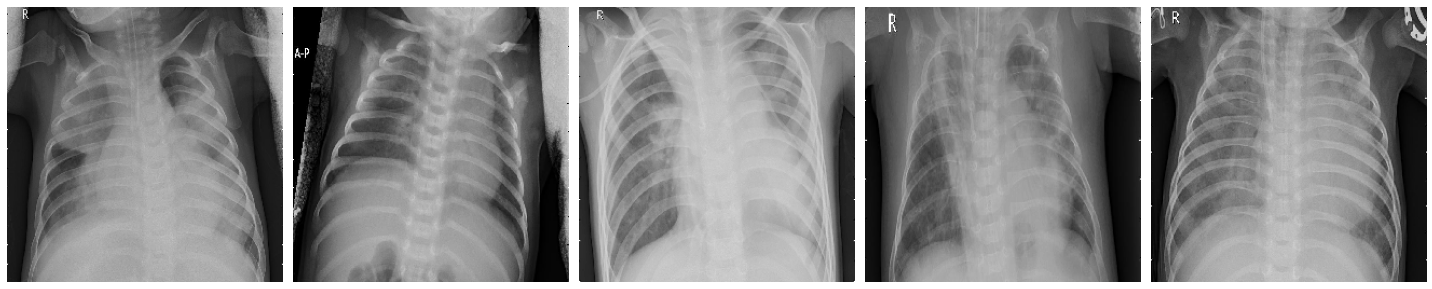

In [9]:
sample_training_images, _ = next(train_data_gen)
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
# from https://www.tensorflow.org/tutorials/images/classification
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        # show grayscale image
        ax.imshow(img[:,:,0], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    fig.savefig(r"images/xray_sample.png", format="png")
plotImages(sample_training_images[:5])

## Simple CNN (with dropout)

In [10]:
# Architecture
# Should we add the final activation or not? # Activation('sigmoid')
# cnn_1 = tf.keras.models.load_model('cnn_1.h5')
cnn_1 = Sequential([Conv2D(filters=16, kernel_size=4, strides=(1, 1), padding='same', activation='relu',
                          input_shape=(params['img_h'], params['img_w'], 1)),
                    MaxPool2D(pool_size=(8, 8), strides=(8, 8), padding='same'),
                    Dropout(rate=0.2),
                    Conv2D(filters=32, kernel_size=4, strides=(1, 1), padding='same', activation='relu'),
                    MaxPool2D(pool_size=(4, 4), strides=(4, 4), padding='same'),
                    Dropout(rate=0.2),
                    Flatten(),
                    Dense(units=512, activation='relu'),
                    Dropout(rate=0.2),
                    Dense(units=1),
                   ])

In [11]:
#cnn_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 
# if sigmoind activation is used in the model
cnn_1.compile(optimizer='adam', 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy']
             )

print(cnn_1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

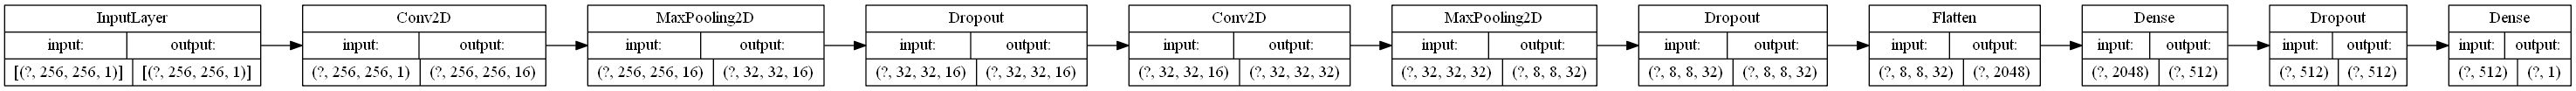

In [15]:
# Plot model
tf.keras.utils.plot_model(cnn_1, to_file=r"images/cnn_dropout.png", rankdir='LR', show_layer_names=False, show_shapes=True)

In [12]:
history = cnn_1.fit_generator(train_data_gen,
                              steps_per_epoch=len(train_data_gen),
                              epochs=params['epochs'],
                              validation_data=val_data_gen,
                              validation_steps=len(val_data_gen)
                             )

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 3 steps
Epoch 1/30
19/19 [==============================] - 49s 3s/step - loss: 0.6060 - accuracy: 0.6251 - val_loss: 0.5535 - val_accuracy: 0.7620
Epoch 2/30
19/19 [==============================] - 49s 3s/step - loss: 0.4178 - accuracy: 0.8228 - val_loss: 0.3404 - val_accuracy: 0.8311
Epoch 3/30
19/19 [==============================] - 48s 3s/step - loss: 0.2525 - accuracy: 0.8880 - val_loss: 0.2711 - val_accuracy: 0.8637
Epoch 4/30
19/19 [==============================] - 52s 3s/step - loss: 0.1913 - accuracy: 0.9212 - val_loss: 0.2043 - val_accuracy: 0.8887
Epoch 5/30
19/19 [==============================] - 48s 3s/step - loss: 0.1696 - accuracy: 0.9289 - val_loss: 0.1697 - val_accuracy: 0.8983
Epoch 6/30
19/19 [==============================] - 48s 3s/step - loss: 0.1426 - accuracy: 0.9431 - val_loss: 0.1695 - val_accuracy: 

In [84]:
cnn_1.save('cnn_1.h5')

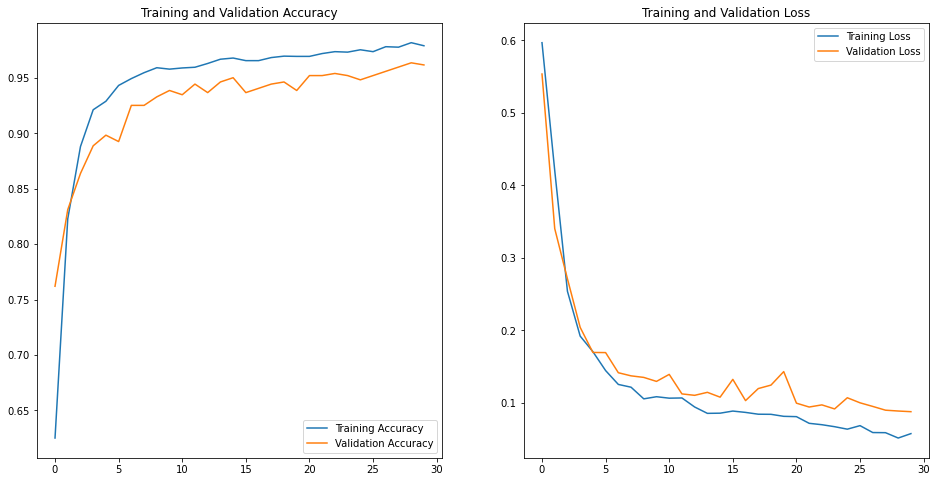

In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(params['epochs'])

fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
fig.savefig(r"images/Epochs_acc_and_loss.png", format="png")

## Perfromance on Validation set

In [34]:
# Quickfix for the the Keras shuffle issue
val_data_gen.shuffle = False
val_data_gen.index_array = None

In [35]:
# Sigmoid function
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [36]:
# Make sure normal is 0 and Pneumonia is 1
val_data_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [45]:
# Create arrays for y, y_hat and likelihoods
pred_probs = sigmoid(cnn_1.predict_generator(val_data_gen))
pred = (pred_probs > 0.5) * 1
actual = val_data_gen.classes.reshape(-1,1)

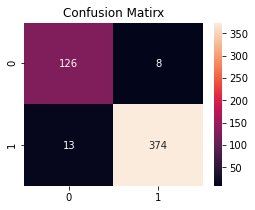

In [68]:
# Confusion matrix
cf = confusion_matrix(actual, pred)
fig = plt.figure(figsize = (4,3))
plt.title('Confusion Matirx')
ax = fig.gca()
sn.heatmap(cf, annot=True,fmt='g')
fig.savefig(r"images/ConfusionMatrix.png", format="png")

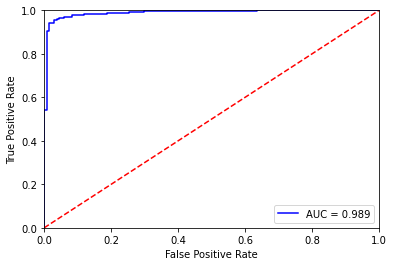

In [88]:
# ROC curve
fpr, tpr, _ = roc_curve(actual, pred_probs)
cnn_auc = auc(fpr, tpr)
fig = plt.figure()
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % cnn_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
fig.savefig(r"images/ROC_curve.png", format="png")